<a href="https://colab.research.google.com/github/InvestitoreComune/analisi_portafogli/blob/main/Leva_finanziaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerie

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn
import plotly.graph_objects as go
from matplotlib.ticker import PercentFormatter

<ipython-input-1-e4c5d50d3a6f>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


#Elaborazione

## Funzioni

In [2]:
def rendimento(prezzi):
  return np.log(prezzi/prezzi.shift(1)).dropna()

In [3]:
def max_drawdown(returns):
    wealth = (1 + returns).cumprod()
    previous_peaks = wealth.cummax()
    drawdowns = (wealth - previous_peaks) / previous_peaks
    return np.min(drawdowns,axis=0)

In [4]:
def compouding_rolling(tf):
  r = reale.resample('M').sum()
  rr = r.rolling(window=12*tf, min_periods=12*tf).sum().dropna()
  rr.index = rr.index - pd.DateOffset(years=tf)

  s = simulato.resample('M').sum()
  ss = s.rolling(window=12*tf, min_periods=12*tf).sum().dropna()
  ss.index = ss.index - pd.DateOffset(years=tf)

  comp_rolling = pd.DataFrame()
  comp_rolling['Compounding Leva 2 Rolling'] = rr.iloc[:,1]-ss.iloc[:,1]
  comp_rolling['Compounding Leva 3 Rolling'] = rr.iloc[:,2]-ss.iloc[:,2]

  return comp_rolling

In [5]:
# leva simulata
def rendim(r):
  rr = (1+r).cumprod()-1
  return rr.iloc[-1]

def rendim2(r):
  return r.mean()*252

def simulazione(roll=10):
  anno = sp_rend.index.year.unique()
  minanno = anno[:-roll]
  pf_noleva = []
  pf_leva2 = []
  pf_leva3 = []

  for a in minanno:
    l = sp_rend[(sp_rend.index.year>=a) & (sp_rend.index.year<a+roll)]
    pf_noleva.append(rendim2(l))
    pf_leva2.append(rendim2(l*2))
    pf_leva3.append(rendim2(l*3))

  portafogli = pd.DataFrame(pf_noleva)
  portafogli['Leva 2'] = pd.DataFrame(pf_leva2)
  portafogli['Leva 3'] = pd.DataFrame(pf_leva3)
  portafogli.index=minanno

  return portafogli

## Input

In [6]:
#tickers = ['QQQ','QLD','TQQQ'] # NASDAQ
tickers = ['VOO','SSO','UPRO'] # S&P500

## Analisi totale

In [7]:
p = yf.download(tickers)['Adj Close']
reale = rendimento(p)

ticker = tickers[0]
prezzi = yf.download(ticker,start=reale.index.min()-pd.Timedelta(days=1))['Adj Close']
close = yf.download(ticker,start=reale.index.min()-pd.Timedelta(days=1))['Adj Close']
logReturns = rendimento(prezzi)
logClose = rendimento(close)

simulato = pd.DataFrame(logReturns)
simulato['Leva 2'] = logClose*2
simulato['Leva 3'] = logClose*3

reale = reale.reindex(tickers,axis=1)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
reale.reindex(tickers,axis=1).describe()

,VOO,SSO,UPRO
count,3245.000000,3245.000000,3245.000000
mean,0.000509,0.000806,0.001008
std,0.011031,0.022105,0.033355
min,-0.124870,-0.266028,-0.429954
25%,-0.003648,-0.007437,-0.011037
50%,0.000716,0.001275,0.001959
75%,0.005779,0.011132,0.016723
max,0.091087,0.173053,0.246592


In [9]:
simulato.describe()

,Adj Close,Leva 2,Leva 3
count,3245.000000,3245.000000,3245.000000
mean,0.000509,0.001017,0.001526
std,0.011031,0.022063,0.033094
min,-0.124870,-0.249739,-0.374609
25%,-0.003648,-0.007296,-0.010944
50%,0.000716,0.001433,0.002149
75%,0.005779,0.011557,0.017336
max,0.091086,0.182173,0.273260


In [10]:
print('Leva 2 - Simulata vs Reale')
print(f"Rendimento Simulato: {simulato.iloc[:,1].mean()*252*100:.2f}%")
print(f"Rendimento Reale: {reale.iloc[:,1].mean()*252*100:.2f}%")
print(f"StDev Simulato: {np.std(simulato.iloc[:,1])*np.sqrt(252)*100:.2f}%")
print(f"StDev Reale: {np.std(reale.iloc[:,1])*np.sqrt(252)*100:.2f}%")
print(f"Max DD Simulato: {max_drawdown(simulato.iloc[:,1])*100:.2f}%")
print(f"Max DD Reale: {max_drawdown(reale.iloc[:,1])*100:.2f}%")
print('\nLeva 3 - Simulata vs Reale')
print(f"Rendimento Simulato: {simulato.iloc[:,2].mean()*252*100:.2f}%")
print(f"Rendimento Reale: {reale.iloc[:,2].mean()*252*100:.2f}%")
print(f"StDev Simulato: {np.std(simulato.iloc[:,2])*np.sqrt(252)*100:.2f}%")
print(f"StDev Reale: {np.std(reale.iloc[:,2])*np.sqrt(252)*100:.2f}%")
print(f"Max DD Simulato: {max_drawdown(simulato.iloc[:,2])*100:.2f}%")
print(f"Max DD Reale: {max_drawdown(reale.iloc[:,2])*100:.2f}%")

Leva 2 - Simulata vs Reale
Rendimento Simulato: 25.64%
Rendimento Reale: 20.31%
StDev Simulato: 35.02%
StDev Reale: 35.08%
Max DD Simulato: -62.18%
Max DD Reale: -64.95%

Leva 3 - Simulata vs Reale
Rendimento Simulato: 38.46%
Rendimento Reale: 25.40%
StDev Simulato: 52.53%
StDev Reale: 52.94%
Max DD Simulato: -79.43%
Max DD Reale: -84.37%


## Effetto compounding

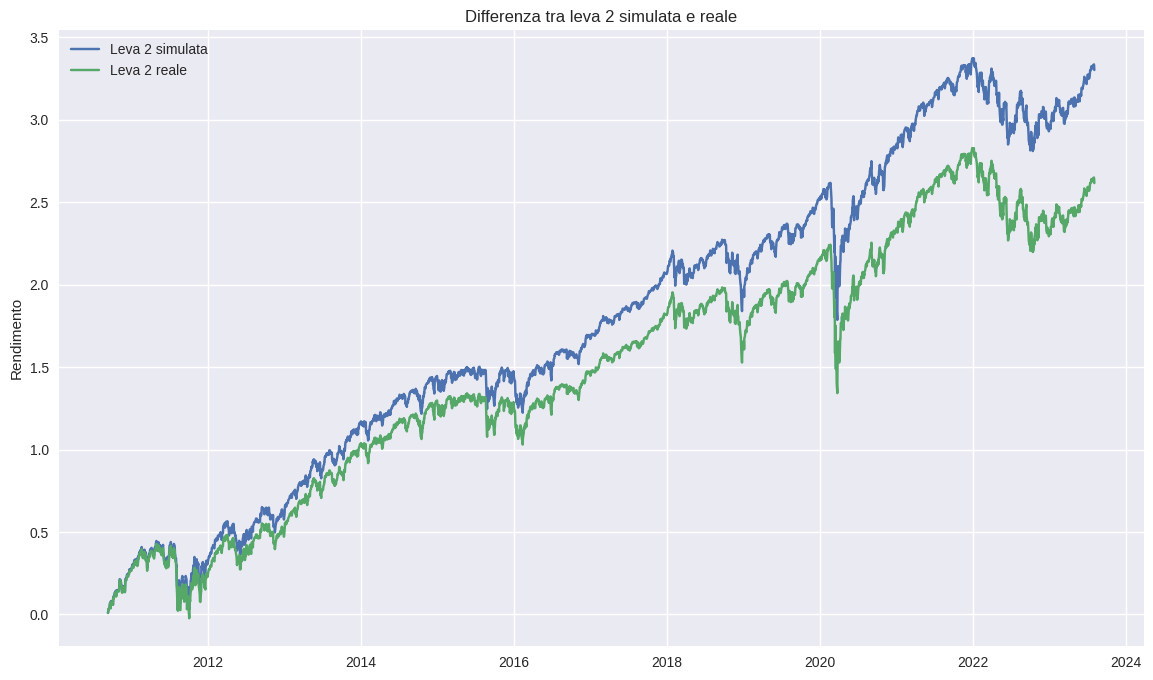

In [11]:
# leva 2
plt.figure(figsize=(14,8))
plt.plot(simulato.iloc[:,1].cumsum(),label='Leva 2 simulata')
plt.plot(reale.iloc[:,1].cumsum(),label='Leva 2 reale')
plt.title('Differenza tra leva 2 simulata e reale')
plt.legend()
plt.ylabel("Rendimento")
plt.show()

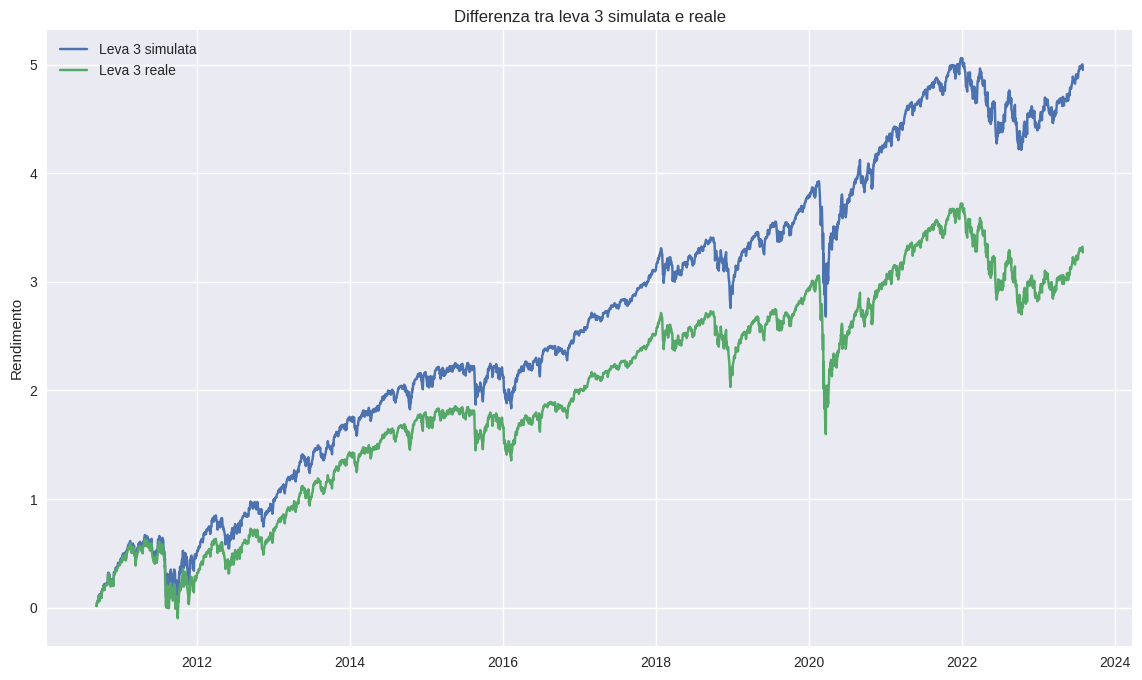

In [12]:
# leva 3
plt.figure(figsize=(14,8))
plt.plot(simulato.iloc[:,2].cumsum(),label='Leva 3 simulata')
plt.plot(reale.iloc[:,2].cumsum(),label='Leva 3 reale')
plt.title('Differenza tra leva 3 simulata e reale')
plt.ylabel("Rendimento")
plt.legend()
plt.show()

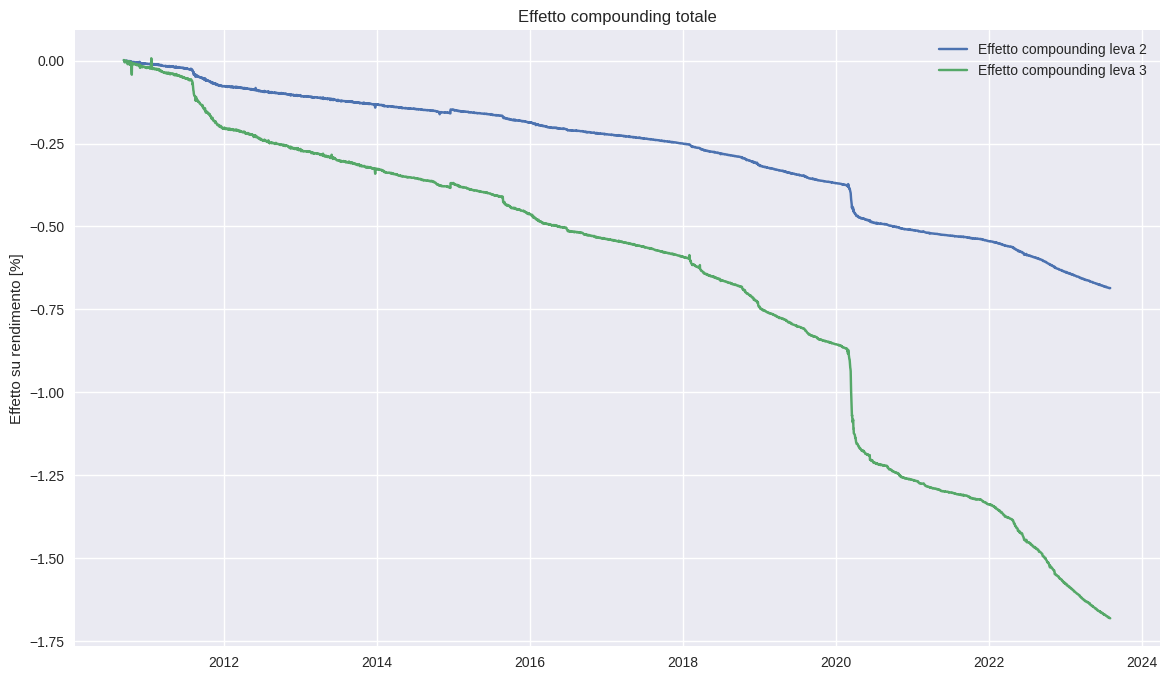

In [13]:
# effetto compouding totale
plt.figure(figsize=(14,8))
plt.plot(reale.iloc[:,1].cumsum()-simulato.iloc[:,1].cumsum(), label='Effetto compounding leva 2')
plt.plot(reale.iloc[:,2].cumsum()-simulato.iloc[:,2].cumsum(), label='Effetto compounding leva 3')
plt.title('Effetto compounding totale')
plt.ylabel("Effetto su rendimento [%]")
plt.legend()
plt.show()

In [14]:
#effetto compouding rolling
comp3 = compouding_rolling(3)
comp5 = compouding_rolling(5)

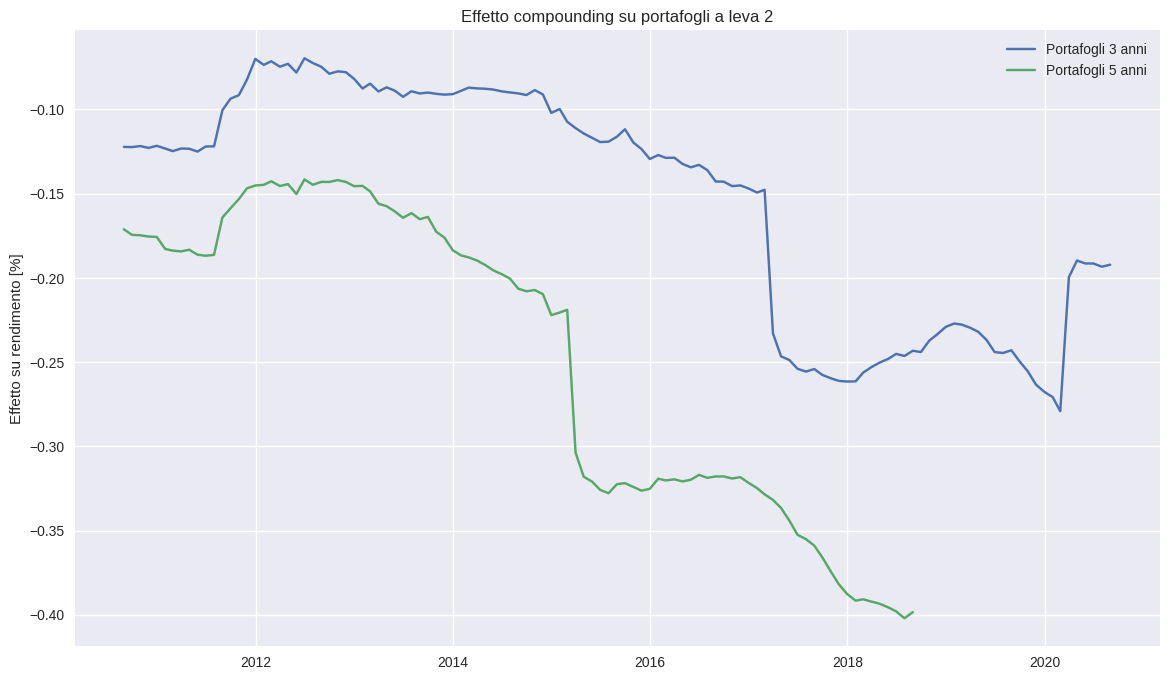

In [15]:
# grafico leva 2
plt.figure(figsize=(14,8))
plt.plot(comp3.iloc[:,0], label='Portafogli 3 anni')
plt.plot(comp5.iloc[:,0], label='Portafogli 5 anni')
plt.title('Effetto compounding su portafogli a leva 2')
plt.ylabel("Effetto su rendimento [%]")
plt.legend()
plt.show()

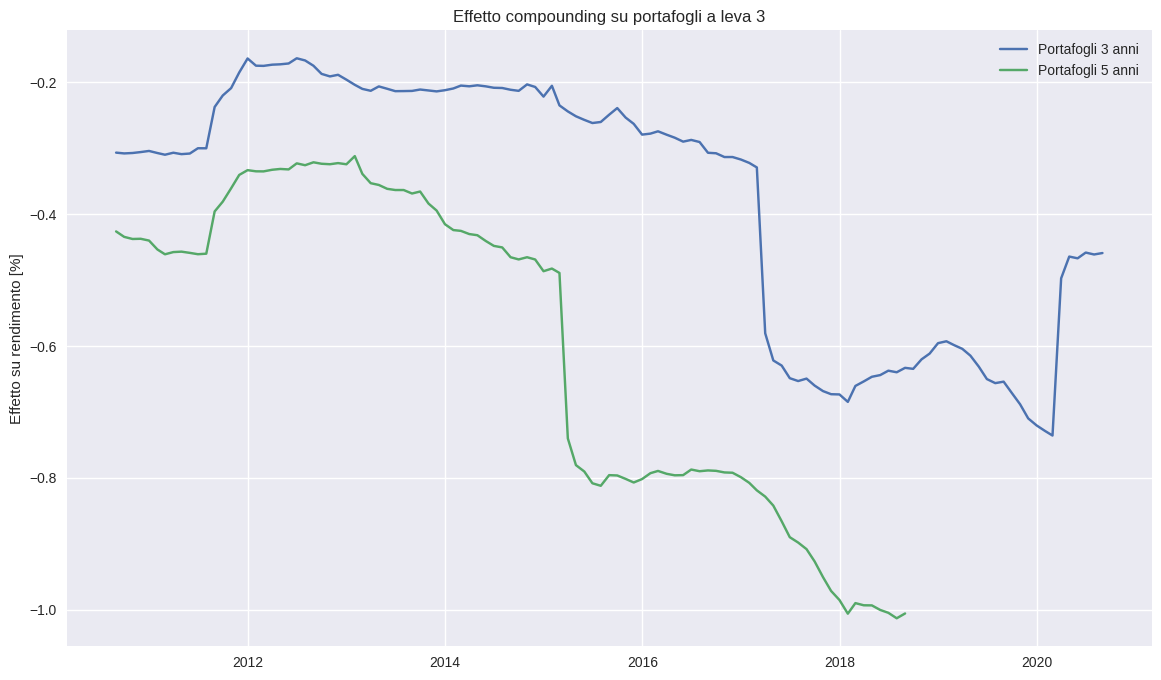

In [16]:
# grafico leva 3
plt.figure(figsize=(14,8))
plt.plot(comp3.iloc[:,1], label='Portafogli 3 anni')
plt.plot(comp5.iloc[:,1], label='Portafogli 5 anni')
plt.title('Effetto compounding su portafogli a leva 3')
plt.ylabel("Effetto su rendimento [%]")
plt.legend()
plt.show()

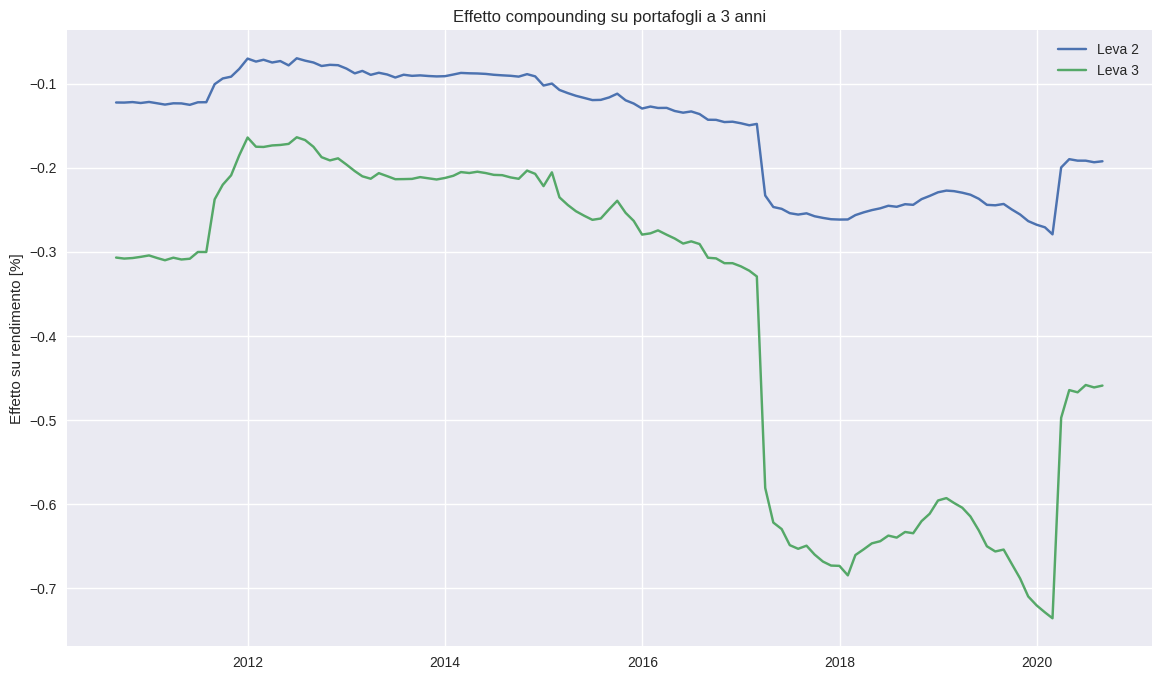

In [17]:
# grafico a 3 anni
plt.figure(figsize=(14,8))
plt.plot(comp3.iloc[:,0], label='Leva 2')
plt.plot(comp3.iloc[:,1], label='Leva 3')
plt.title('Effetto compounding su portafogli a 3 anni')
plt.ylabel("Effetto su rendimento [%]")
plt.legend()
plt.show()

## Analisi drawdown

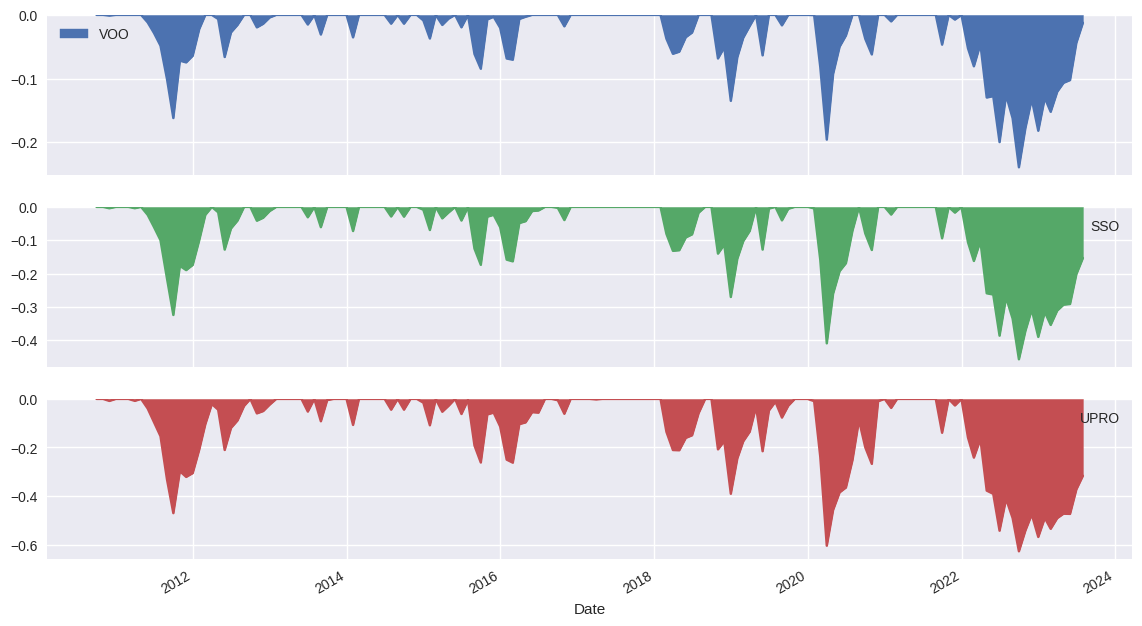

In [23]:
dd = pd.DataFrame()
prezziMensili = p.resample('M').last().dropna()

for i in range(len(prezziMensili.index)):
  dd = pd.concat([dd,prezziMensili.iloc[0:i]/prezziMensili.iloc[:i].cummax()-1])

dd = dd.reindex(tickers, axis=1)
dd.plot.area(figsize=(14,8), subplots=True)
plt.show()

In [19]:
# S&P/NASDAQ
benchmark = ['^GSPC']
#benchmark = ['^IXIC']
sp_prezzo = yf.download(benchmark)['Adj Close']
sp_rend = np.log(sp_prezzo/sp_prezzo.shift(1)).dropna()

sp_dd = pd.DataFrame()
benchmark_mese = sp_prezzo.resample('M').last().dropna()

for i in range(len(benchmark_mese.index)):
  sp_dd = pd.concat([sp_dd,benchmark_mese.iloc[0:i]/benchmark_mese.iloc[:i].cummax()-1])

#sp_dd.rename(columns={'0': 'Drawdown'},inplace=True)

[*********************100%***********************]  1 of 1 completed


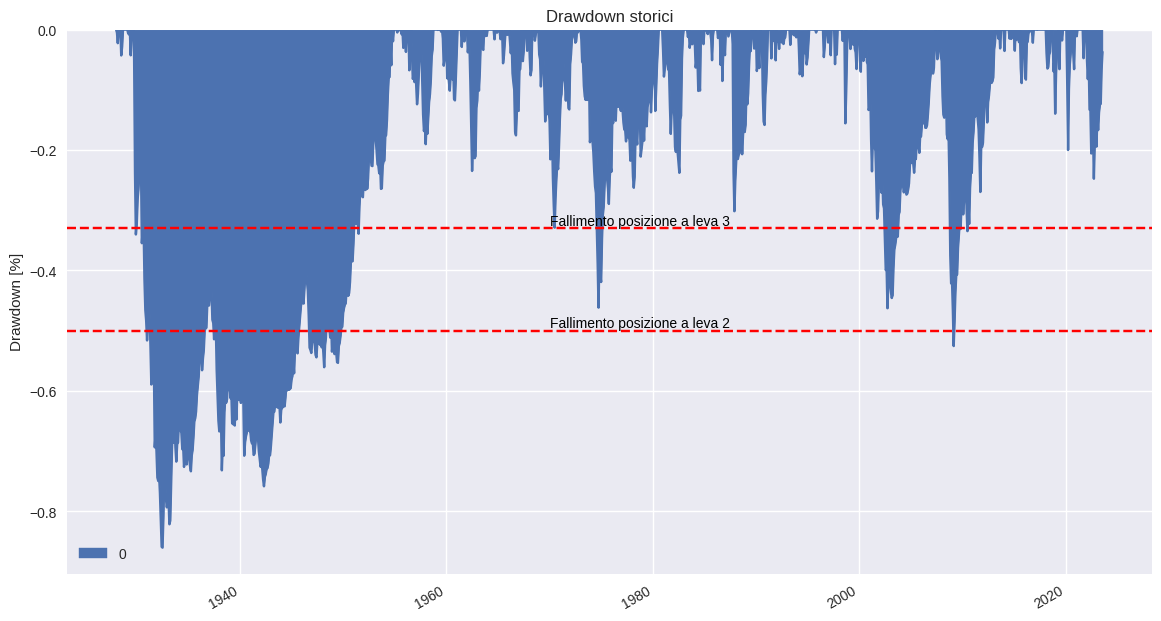

In [25]:
#grafico s&p500
sp_dd.plot.area(figsize=(14,8))
plt.axhline(y=-0.33, color='r', linestyle='--', label='Fallimento posizione a leva 3')
plt.axhline(y=-0.5, color='r', linestyle='--', label='Fallimento posizione a leva 2')
plt.text(0, -0.33, 'Fallimento posizione a leva 3', color='black', ha='left', va='bottom')
plt.text(0, -0.5, 'Fallimento posizione a leva 2', color='black', ha='left', va='bottom')
plt.ylabel("Drawdown [%]")
plt.title("Drawdown storici")
plt.show()

# Simulazione ETF a leva

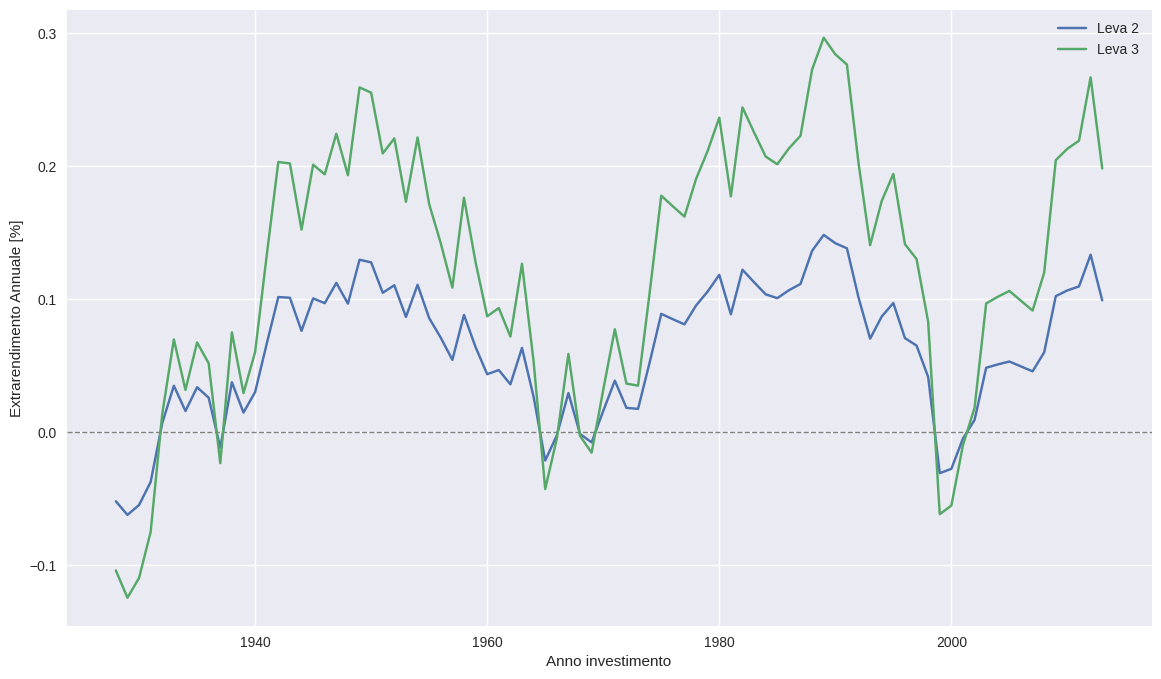

In [21]:
pff = simulazione(10)
diff = pd.DataFrame()
diff['Leva 2'] = pff.iloc[:,1]-pff.iloc[:,0]
diff['Leva 3'] = pff.iloc[:,2]-pff.iloc[:,0]

plt.figure(figsize=(14,8))
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.plot(diff.iloc[:,0], label='Leva 2')
plt.plot(diff.iloc[:,1], label='Leva 3')
plt.legend()
plt.xlabel('Anno investimento')
plt.ylabel('Extrarendimento Annuale [%]')
plt.show()